In [260]:
import pandas as pd
import numpy as np
import os
import glob
import pymatgen as mg
import plot_misc2
from shutil import copyfile

import pypif.pif
from pypif.obj import *
from citrination_client import CitrinationClient
import matplotlib.pyplot as plt
%matplotlib inline
import helpers.fileload as fl
#from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.plotting import add_colorbar
from helpers.predict import predict_from_pifs
import warnings

In [2]:
pypif.pif

<module 'pypif.pif' from 'C:\\Users\\jdh10\\Anaconda3\\lib\\site-packages\\pypif\\pif.py'>

In [12]:
# %load_ext autoreload
# %autoreload 2
os.chdir(os.path.join(tcodir,'scripts/EIS_analysis'))
from calc_chemfeat import perovskite

## Data load process

In [66]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis')
pifdir = os.path.join(datadir,'pifs')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

# def get_all_conditions(sample,src):
#     orig = os.getcwd()
#     os.chdir(sampledir(sample,src=src))
#     conditions = []
#     for file in glob.glob('*.txt'):
#         info = get_file_info(file,sample)
#         cond = info[-2:]
#         conditions.append(cond)
    
#     os.chdir(orig) #return to original directory
#     return np.unique(conditions,axis=0)

# def load_condition_files(sample,src,condition,append_cond=False):
#     orig = os.getcwd()
#     os.chdir(sampledir(sample,src=src))
#     cond_str = '_'.join(condition) + '.txt'
#     df = pd.DataFrame()
#     for file in glob.glob('*' + cond_str):
#         tdf = pd.read_csv(file,sep='\t',index_col=0)
#         df = df.join(tdf,how='outer')
#     if append_cond==True:
#         df.loc[:,'T_set'] = condition[0]
#         df.loc[:,'Atmosphere'] = condition[1].lower()
#         #move point to a column and make composite index
#         df.loc[:,'Point'] = df.index
#         df.index = df.index.astype(str) + '_' + df.T_set + '_' + df.Atmosphere
#         df.index.rename('Point_condition',inplace=True)
    
#     os.chdir(orig) #return to original directory
#     return df

# def copy_compfiles(sample,srccond,dstcond): #create missing composition files
#     #within a sample, composition is same for all conditions. 
#     #Copy src conditon composition files
#     orig = os.getcwd()
#     os.chdir(sampledir(sample))
#     elements = ['Ba','Co','Fe','Y','Zr']
#     for el in elements:
#         srcname = '_'.join([sample,el,'at',srccond]) + '.txt'
#         dstname = srcname.replace(srccond,dstcond)
#         copyfile(srcname,dstname)
#         print('Copied {} to {}'.format(srcname,dstname))
    
#     os.chdir(orig) #return to original directory



# def load_sample(sample,src):
#     '''
#     Loads all files for sample into DataFrame
#     '''
#     T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5} #map tempId to order
#     T_act = {'300C':265,'400C':351,'500C':437,'401C':351,'301C':265} #map tempId to actual temp
    
#     conditions = get_all_conditions(sample,src=src)

#     df = pd.DataFrame()
#     for cond in conditions:
#         tdf = load_condition_files(sample,src,cond,append_cond=True)
#         get_formula(tdf,overwrite=True)
#         #print(cond,tdf.columns)
#         df = df.append(tdf,sort=True)

#     df['T_order'] = df['T_set'].map(T_order)
#     df['T_act'] = df['T_set'].map(T_act)
#     df['T(K)'] = df['T_act'] + 273
    
#     return df

def fit_df(df, min_R2=0.8, show_dist=False,show_R2=False):
    '''
    Fit ASR to Arrhenius to get slope and intercept. Resulting DataFrame has 1 row for each point
    If a single point has data for multiple conditions, conditions and properties are stored as a list
    '''
    k_B = 8.61733e-5 #Boltzmann constant in eV/K
    
    #fit each point for each atmosphere condition
    fit = fl.fit_by_group(df,x=1/df['Temp_K'],y=np.log(1/df['ASR']),groupby=['Point','formula','atm'])
    
    if show_R2==True:
        fig, ax = plt.subplots()
        grptemp = fit.groupby('atm')
        for name, group in grptemp:
            group['R2'].hist(alpha=0.5,label=name,ax=ax,grid=False,density=True)
            ax.legend()
            ax.set_title(sample)
            ax.set_xlabel('$R^2$')
            ax.set_ylabel('Density')
        ax.set_title('{} $R^2$ distribution'.format(sample))
        plt.show()
    
    #flag bad data
    fit['bad_flag'] = 0
    for idx in fit.index:
        row = fit.loc[idx,:]
        if row['m'] > 0 or row['R2'] < min_R2: #positive slopes or R2 below threshold
            fit.loc[idx,'bad_flag'] = 1
    
    print('{}: flagged {} points out of {} with bad fits'.format(sample, len(fit[fit['bad_flag']==1]), len(fit)))

    fit['E_a'] = fit['m']*-k_B

    fit_grp = fit.groupby('atm')
    fit_agg = fit.groupby(['Point','formula']).aggregate(list)
    
    if show_dist==True:
        #check distributions
        good_fits = fit[fit['bad_flag']==0]
        gfg = good_fits.groupby('atm')
        fig, ax = plt.subplots()
        for name, group in gfg:
            group['E_a'].hist(alpha=0.5,label=name,ax=ax,grid=False,density=True)
            ax.legend()
            ax.set_title(sample)
            ax.set_xlabel('$E_a$ (eV)')
            ax.set_ylabel('Density')
        ax.set_title('{} $E_a$ distribution'.format(sample))
        plt.show()
            
    return fit_agg


# def formula_redfeat(formula,cat_ox_lims={}):
#     pvskt = perovskite(formula,site_ox_lim={'A':[2,4],'B':[2,4]},site_base_ox={'A':2,'B':4})
#     for k,v in cat_ox_lims.items():
#         pvskt.set_cat_ox_lim(k,v)
#     pvskt.featurize()
#     red_feat = {'{}'.format(k):v for (k,v) in pvskt.features.items() 
#                 if k[-5:] not in ['oxmin','oxmax'] and k[0:7]!='O_delta'}
#     return red_feat

# def formula_pif(formula,cat_ox_lims={},red_feat=None):
#     '''
#     create pif with formula and chemical feature properties
#     '''
#     fpif = ChemicalSystem()
#     fpif.chemical_formula = formula
#     if red_feat is None:
#         red_feat = formula_readfeat(formula,cat_ox_lims)
    
#     props = []
#     for feat, val in red_feat.items():
#         prop = Property(name=feat,scalars=val)
#         props.append(prop)
#     fpif.properties=props
    
#     return fpif, red_feat

def formula_sigma_input(formula,cat_ox_lims={}):
    pvskt = perovskite(formula,site_ox_lim={'A':[2,4],'B':[2,4]},site_base_ox={'A':2,'B':4})
    for k,v in cat_ox_lims.items():
        pvskt.set_cat_ox_lim(k,v)
    pvskt.featurize()
    red_feat = {'Property {}'.format(k):v for (k,v) in pvskt.features.items() 
                if k[-5:] not in ['oxmin','oxmax'] and k[0:7]!='O_delta'}

    base_inp = {'Atmosphere':'dry','Temperature ($^\circ$C)':473}
    inp_dict = {**base_inp,**red_feat}
    return inp_dict

# def pif_from_fit(fit_agg,cat_ox_lims={}):
#     '''
#     Convert to fit_agg df to pifs. Each point has its own pif
#     All pifs for sample are dumped to json file in dest directory
#     ''' 
# #     outfile = os.path.join(dest,'{}_pif.json'.format(sample))
# #     file = open(outfile,'w')

#     pifs = []
    
#     for i in range(len(fit_agg)):
#         row = fit_agg.iloc[i,:]
#         row_pif = ChemicalSystem()
#         "Identifiers"
#         sample_num = Id(name='Sample', value=sample[-5:])
#         point = Id(name='Point',value=int(row.name[0])) #multipart index (point,formula)
#         row_pif.ids = [sample_num, point]
#         "Formula"
#         row_pif.chemical_formula = row.name[1] #multipart index (point,formula)
#         "Properties"
#         #output properties - "labels"
#         act_energy = Property(name='$E_a$',units='eV',scalars=row['E_a'])
#         act_energy.conditions = [Value(name='Atmosphere',scalars=row['atm'])]
#         props = [act_energy]
#         #input propertes - "features"
#         pvskt = perovskite(formula=row.name[1], site_ox_lim={'A':[2,4],'B':[3,4]},site_base_ox={'A':2,'B':4})
#         for k,v in cat_ox_lims.items():
#             pvskt.set_cat_ox_lim(k,v)
#         pvskt.featurize()
#         red_feat = {'Property {}'.format(k):v for (k,v) in pvskt.features.items() 
#                 if k[-5:] not in ['oxmin','oxmax'] and k[0:7]!='O_delta'}
        
#         for feat, val in red_feat.items():
#             prop = Property(name=feat,scalars=val)
#             props.append(prop)
#         row_pif.properties=props
        
#         pifs.append(pif)
#         #pif.dump(row_pif,file)
        
# #     file.close()    
# #     print('Dumped {} pifs in {}'.format(len(fit_agg), os.path.basename(outfile)))
#     return pifs
    

In [3]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis')
pifdir = os.path.join(datadir,'pifs')
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

In [128]:
"make pifs with 500C dry ASR only"
cat_ox_lims = {'Co':[2,3],'Fe':[3,4]}
dest = 'dryASR_Co(2,3)Fe(3,4)'
max_ASR = 2e7
src = 'in'

viewid_2334 = '5042'
viewid_2424 = '5044'

destdir = os.path.join(pifdir,dest)

T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5} #map tempId to order

include_T_ord = {'PDAC_COM3_01542':{'wet':[3,4,5],'dry':[1,2,3,4,5]}, #missing dry 401C
                 'PDAC_COM3_01545':{'wet':[3,4,5],'dry':[1,2,3,4,5]}, #missing dry ramp down
                 'PDAC_COM3_01564':{'wet':[1,2,3],'dry':[1,2,3]}, #missing ramp down
                 'PDAC_COM3_01566':{'wet':[1,2,3,4,5],'dry':[1,2,3,4,5]} #missing ramp down for points 42-132
                }

samples = next(os.walk(os.path.join(datadir,src)))[1]

#save red_feat for reuse
try:
    calc_feat_Co24Fe24 #{(sample,point):red_feat}
except NameError:
    calc_feat_Co24Fe24 = {}

try:
    calc_feat_Co23Fe34
except NameError:
    calc_feat_Co23Fe34 = {}

#save sigma predictions for reuse
try:
    sample_sigma2334 #{sample:{point:sigma}}
    sample_log_sigma2334
except NameError:
    sample_sigma2334 = {}
    sample_log_sigma2334 = {}
    
try:
    sample_sigma2424
    sample_log_sigma2424
except NameError:
    sample_sigma2424 = {}
    sample_log_sigma2424 = {}

for sample in samples:
    print('------------------\nProcessing {}\n------------------'.format(sample))
    "get ASRs at 500C dry"
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
    df['ASR'].replace(0,np.nan)
    fl.get_formula(df,overwrite=True)
    
    #remove any ASRs above threshold
    df = df.loc[df['ASR']<=max_ASR,:]
    
    #add log(ASR)
    df['logASR'] = np.log10(df['ASR'])
    
    pifs = {} #{point:pif}
    sigma_inp_2334 = {} #{point:inp_dict}
    sigma_inp_2424 = {}
    base_inp = {'Atmosphere':'dry','Temperature ($^\circ$C)':473} #for sigma prediction
    
    n_feat_calc = 0
    
    for idx in df.index:
        row = df.loc[idx,:]
        formula = row['formula']
        point = row['Point']
        if cat_ox_lims == {'Co':[2,4],'Fe':[2,4]}:
            try:
                red_feat = calc_feat_Co24Fe24[(sample,point)]
            except KeyError:
                red_feat = formula_redfeat(formula,cat_ox_lims=cat_ox_lims)
                calc_feat_Co24Fe24[(sample,point)] = red_feat
                n_feat_calc += 1
        elif cat_ox_lims == {'Co':[2,3],'Fe':[3,4]}:
            try:
                red_feat = calc_feat_Co23Fe34[(sample,point)]
            except KeyError:
                red_feat = formula_redfeat(formula,cat_ox_lims=cat_ox_lims)
                calc_feat_Co23Fe34[(sample,point)] = red_feat
                n_feat_calc += 1
        else:
            raise Exception('cat_ox_lims {} does not match expected cases'.format(cat_ox_lims))
            
        row_pif, red_feat = formula_pif(formula,cat_ox_lims=cat_ox_lims,red_feat=red_feat)
        
        
        "Identifiers"
        sample_num = Id(name='Sample', value=sample[-5:])
        pointid = Id(name='Point',value=int(row['Point']))
        row_pif.ids = [sample_num, pointid]
        "ASR"
        ASR = Property(name='ASR',units='$\Omega$*cm$^2$',scalars=row['ASR'])
        ASR.conditions = [Value(name='Atmosphere',scalars=row['atm']),
                          Value(name='Temperature ($^\circ$C)',scalars=int(row['Temp_C']))]
        "log ASR"
        logASR = Property(name='logASR',scalars=row['logASR'])
        logASR.conditions = [Value(name='Atmosphere',scalars=row['atm']),
                          Value(name='Temperature ($^\circ$C)',scalars=int(row['Temp_C']))]
        row_pif.properties = row_pif.properties + [ASR,logASR]
        pifs[point] = row_pif
        
        #prep inputs for sigma prediction
        try:
            sample_sigma2334[sample][point]
            sample_log_sigma2334[sample][point]
            sample_sigma2424[sample][point]
            sample_log_sigma2424[sample][point]
        except KeyError:
            #use red_feat for inputs if possible
            if cat_ox_lims == {'Co':[2,4],'Fe':[2,4]}: #matches 2424
                red_inp_2424 = {'Property {}'.format(k):v for (k,v) in red_feat.items()}
                inp_dict_2424 = {**base_inp,**red_inp_2424}
                sigma_inp_2424[point] = inp_dict_2424
                #need to generate features for 2334
                red_inp_2334 = formula_sigma_input(formula,cat_ox_lims={'Co':[2,3],'Fe':[3,4]})
                inp_dict_2334 = {**base_inp,**red_inp_2334}
                sigma_inp_2334[point] = inp_dict_2334
            elif cat_ox_lims == {'Co':[2,3],'Fe':[3,4]}: #matches 2334
                red_inp_2334 = {'Property {}'.format(k):v for (k,v) in red_feat.items()}
                inp_dict_2334 = {**base_inp,**red_inp_2334}
                sigma_inp_2334[point] = inp_dict_2334
                #need to generate features for 2424
                red_inp_2424 = formula_sigma_input(formula,cat_ox_lims={'Co':[2,4],'Fe':[2,4]})
                inp_dict_2424 = {**base_inp,**red_inp_2424}
                sigma_inp_2424[point] = inp_dict_2424
            else:
                raise Exception('cat_ox_lims {} for pifs does not match either sigma model'.format(cat_ox_lims))
    
    print('Calculated red_feat for {} pifs'.format(n_feat_calc))
    
    #predict sigma
    if len(sigma_inp_2334) > 0 or len(sigma_inp_2424) > 0:
        results_2334 = client.predict(viewid_2334,list(sigma_inp_2334.values())) #Co[2,3]Fe[3,4]
        results_2424 = client.predict(viewid_2424,list(sigma_inp_2424.values())) #Co[2,4]Fe[2,4]
        sigma_2334 = [res.get_value('Property sigma_e').value for res in results_2334]
        sigma_2424 = [res.get_value('Property sigma_e').value for res in results_2424]
        log_sigma_2334 = [res.get_value('Property log_sigma_e').value for res in results_2334]
        log_sigma_2424 = [res.get_value('Property log_sigma_e').value for res in results_2424]
        new_sigma2334 = dict(zip(sigma_inp_2334.keys(), sigma_2334))
        new_sigma2424 = dict(zip(sigma_inp_2424.keys(), sigma_2424))
        new_log_sigma2334 = dict(zip(sigma_inp_2334.keys(), log_sigma_2334))
        new_log_sigma2424 = dict(zip(sigma_inp_2424.keys(), log_sigma_2424))
        try:
            sample_sigma2334[sample].update(new_sigma2334)
            sample_log_sigma2334[sample].update(new_log_sigma2334)
        except KeyError:
            sample_sigma2334[sample] = new_sigma2334
            sample_log_sigma2334[sample] = new_log_sigma2334
        try:
            sample_sigma2424[sample].update(new_sigma2424)
            sample_log_sigma2424[sample].update(new_log_sigma2424)
        except KeyError:
            sample_sigma2424[sample] = new_sigma2424
            sample_log_sigma2424[sample] = new_log_sigma2424
    
    print('Calculated sigma_pred for {},{} pifs for 2334,2424'.format(len(sigma_inp_2334),len(sigma_inp_2424)))
    
    #add predicted sigma to pif properties
    for point, rp in pifs.items():
        ps2334 = Property(name='pred_sigma_{}'.format(viewid_2334),units='S/cm',scalars=sample_sigma2334[sample][point])
        ps2424 = Property(name='pred_sigma_{}'.format(viewid_2424),units='S/cm',scalars=sample_sigma2424[sample][point])
        pls2334 = Property(name='pred_logsigma_{}'.format(viewid_2334),scalars=sample_log_sigma2334[sample][point])
        pls2424 = Property(name='pred_logsigma_{}'.format(viewid_2424),scalars=sample_log_sigma2424[sample][point])
        rp.properties = rp.properties + [ps2334,ps2424,pls2334,pls2424]
    
    outfile = os.path.join(destdir,'{}_oxavg_pif.json'.format(sample))
    file = open(outfile,'w')
    pypif.pif.dump(list(pifs.values()),file,indent=0)
    file.close()
    print('Dumped {} pifs in {}'.format(len(pifs), os.path.basename(outfile)))

------------------
Processing PDAC_COM3_01488
------------------
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 130 pifs in PDAC_COM3_01488_oxavg_pif.json
------------------
Processing PDAC_COM3_01504
------------------
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 132 pifs in PDAC_COM3_01504_oxavg_pif.json
------------------
Processing PDAC_COM3_01533
------------------
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 121 pifs in PDAC_COM3_01533_oxavg_pif.json
------------------
Processing PDAC_COM3_01535
------------------
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 131 pifs in PDAC_COM3_01535_oxavg_pif.json
------------------
Processing PDAC_COM3_01564
------------------
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 131 pifs in PDAC_COM3_01564_oxavg_pif.json


### Datasets
tco_ASR+Ea_oxavg_Co[2,4]Fe[2,4]: 162834

tco_ASR+Ea_oxavg_Co[2,3]Fe[3,4]: 162835

tco_dryASR_oxavg_Co[2,4]Fe[2,4]: 162836

tco_dryASR_oxavg_Co[2,3]Fe[3,4]: 162837

In [63]:
"general pif upload"
dsid = 162836

upload_dir = os.path.join(pifdir,'dryASR_Co(2,4)Fe(2,4)')

results = []

for file in glob.glob(os.path.join(upload_dir,'*.json')):
    result = client.upload(dsid,file)
    results.append(result)

[r.__dict__ for r in results]

[{'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\dryASR_Co(2,3)Fe(3,4)\\PDAC_COM3_01488_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\dryASR_Co(2,3)Fe(3,4)\\PDAC_COM3_01504_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\dryASR_Co(2,3)Fe(3,4)\\PDAC_COM3_01533_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\dryASR_Co(2,3)Fe(3,4)\\PDAC_COM3_01535_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\dryASR_Co(2,3)Fe(3,4)\\PDAC_COM3_01564_oxavg_pif.json'}]}]

In [52]:
sample_sigma4999

{'PDAC_COM3_01488': {1: 2.0476812518294e-05,
  2: 2.058553932710322e-05,
  3: 1.9397100200561414e-05,
  4: 1.8685375461065052e-05,
  5: 1.78561699754642e-05,
  6: 1.820709005712826e-05,
  7: 1.8515157771835552e-05,
  8: 1.5384592906021928e-05,
  9: 1.3308674717809884e-05,
  10: 8.211332795396135e-06,
  11: 7.125814900006836e-06,
  12: 1.8624705934055047e-05,
  13: 1.9410417385812865e-05,
  14: 1.9463065657198465e-05,
  15: 1.6542767632485268e-05,
  16: 1.7813236681748213e-05,
  17: 1.4287170294046553e-05,
  18: 1.6820370697624664e-05,
  19: 2.7887250969748722e-05,
  20: 1.3211695382211217e-05,
  21: 5.683558316814064e-06,
  22: 6.385400135675318e-06,
  23: 8.294113726125873e-06,
  24: 9.002256800107828e-06,
  25: 8.49051314536056e-06,
  26: 4.6326105557708955e-06,
  27: 2.878560709178234e-06,
  28: 1.8568958625412415e-06,
  29: 1.6932329778425204e-06,
  30: 2.405769181725617e-06,
  31: 9.506265314341718e-07,
  32: 4.996578526382682e-07,
  33: 5.0403070549626015e-06,
  34: 1.64086994734

Text(0.5,0.98,'500C dry ASR Histograms by Threshold')

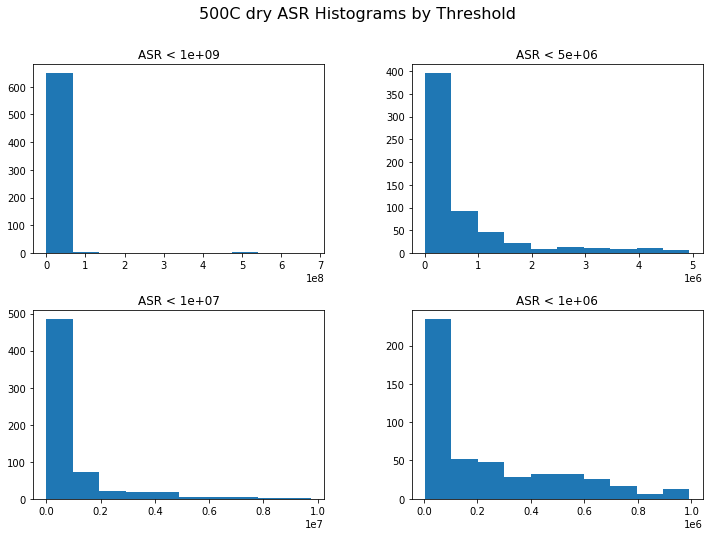

In [7]:
df = pd.DataFrame()
src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    tdf = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
    df = df.append(tdf,sort=True)
df['ASR'].replace(0,np.nan)
lims = [1e9,1e7,5e6,1e6]
fig, axes = plt.subplots(2,2,figsize=(12,8))
for i,lim in enumerate(lims):
    ax = axes[i%2,int(i/2)]    
    df[df['ASR']<lim].hist('ASR',grid=False,ax=ax)
    ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    ax.set_title('ASR < {:.0e}'.format(lim))
plt.suptitle('500C dry ASR Histograms by Threshold',size=16)

Text(0.5,0.98,'500C dry ASR Histograms by Threshold')

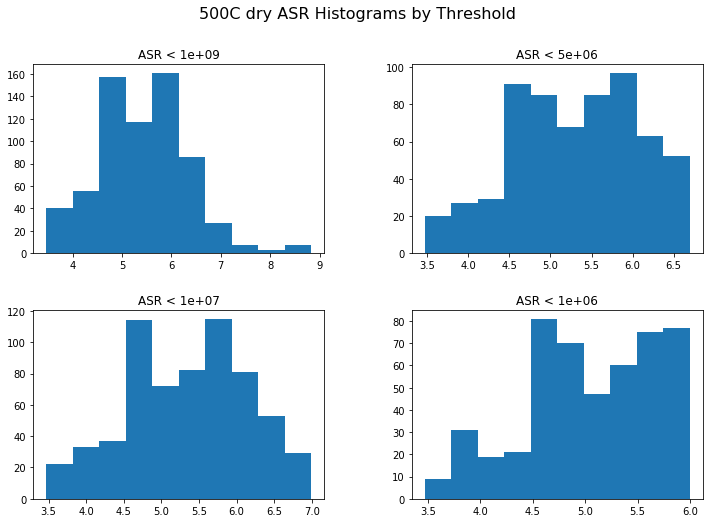

In [10]:
df = pd.DataFrame()
src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    tdf = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry']})
    df = df.append(tdf,sort=True)
df['ASR'].replace(0,np.nan)
df['logASR'] = np.log10(df['ASR'])
lims = [1e9,1e7,5e6,1e6]
fig, axes = plt.subplots(2,2,figsize=(12,8))
for i,lim in enumerate(lims):
    ax = axes[i%2,int(i/2)]    
    df[df['ASR']<lim].hist('logASR',grid=False,ax=ax)
    #ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    ax.set_title('ASR < {:.0e}'.format(lim))
plt.suptitle('500C dry ASR Histograms by Threshold',size=16)

In [126]:
"put 500C ASR and E_a in single pif for each point"
cat_ox_lims = {'Co':[2,4],'Fe':[2,4]}
dest = 'ASR_Ea_Co(2,4)Fe(2,4)'
max_ASR = 2e7
src = 'in'

viewid_2334 = '5042'
viewid_2424 = '5044'

destdir = os.path.join(pifdir,dest)


T_order = {'300C':1,'400C':2,'500C':3,'401C':4,'301C':5} #map tempId to order

include_T_ord = {'PDAC_COM3_01542':{'wet':[3,4,5],'dry':[1,2,3,4,5]}, #missing dry 401C
                 'PDAC_COM3_01545':{'wet':[3,4,5],'dry':[1,2,3,4,5]}, #missing dry ramp down
                 'PDAC_COM3_01564':{'wet':[1,2,3],'dry':[1,2,3]}, #missing ramp down
                 'PDAC_COM3_01566':{'wet':[1,2,3,4,5],'dry':[1,2,3,4,5]} #missing ramp down for points 42-132
                }

samples = next(os.walk(os.path.join(datadir,src)))[1]

#save red_feat for reuse
try:
    calc_feat_Co24Fe24 #{(sample,point):red_feat}
except NameError:
    calc_feat_Co24Fe24 = {}

try:
    calc_feat_Co23Fe34
except NameError:
    calc_feat_Co23Fe34 = {}

#save sigma predictions for reuse
try:
    sample_sigma2334 #{sample:{point:sigma}}
except NameError:
    sample_sigma2334 = {}
    
try:
    sample_sigma2424
except NameError:
    sample_sigma2424 = {}

for sample in samples:
    print('------------------\nProcessing {}\n------------------'.format(sample))
    "get ASRs at 500C"
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C']})
    df['ASR'].replace(0,np.nan)
    fl.get_formula(df,overwrite=True)
    
    #remove any ASRs above threshold
    df = df.loc[df['ASR']<=max_ASR,:]
    
    #add log(ASR)
    df['logASR'] = np.log10(df['ASR'])
    
    dfg = df.groupby(['Point','formula']).agg(list)
    
    "get activation energies"
    #--------------------------
    ea_df = fl.load_sample_files(sampledir(sample,src))

    #remove nans and zeroes
    ea_df = ea_df.loc[pd.isnull(ea_df['ASR'])==False,:]
    ea_df = ea_df.loc[ea_df['ASR']>0,:]
    ea_df['Temp_K'] = ea_df['Temp_C'] + 273
    ea_df['T_order'] = ea_df['T_set'].map(T_order)
    fl.get_formula(ea_df,overwrite=True)

    if sample in include_T_ord.keys():
        tdf = ea_df[(ea_df['atm']=='wet') & (ea_df['T_order'].isin(include_T_ord[sample]['wet'])) | 
                (ea_df['atm']=='dry') & (ea_df['T_order'].isin(include_T_ord[sample]['dry']))]
    else:
        tdf = ea_df[ea_df['T_order']>=3]
    fit_agg = fit_df(tdf,min_R2=0.8,show_dist=False,show_R2=False)
    #fit_agg.sort_values(by='Point',inplace=True)
    
    "join ASR and E_a dataframes"
    #--------------------------
    dfg = dfg.join(fit_agg,rsuffix='_Ea',how='left')
    

    pifs = {} #{point:pif}
    sigma_inp_2334 = {} #{point:inp_dict}
    sigma_inp_2424 = {}
    base_inp = {'Atmosphere':'dry','Temperature ($^\circ$C)':473} #for sigma prediction
    
    n_feat_calc = 0

    for idx in dfg.index:
        row = dfg.loc[idx,:]
        formula = row.name[1]
        point = row.name[0]
        if cat_ox_lims == {'Co':[2,4],'Fe':[2,4]}:
            try:
                red_feat = calc_feat_Co24Fe24[(sample,point)]
            except KeyError:
                red_feat = formula_redfeat(formula,cat_ox_lims=cat_ox_lims)
                calc_feat_Co24Fe24[(sample,point)] = red_feat
                n_feat_calc += 1
        elif cat_ox_lims == {'Co':[2,3],'Fe':[3,4]}:
            try:
                red_feat = calc_feat_Co23Fe34[(sample,point)]
            except KeyError:
                red_feat = formula_redfeat(formula,cat_ox_lims=cat_ox_lims)
                calc_feat_Co23Fe34[(sample,point)] = red_feat
                n_feat_calc += 1
                print(sample,point)
        else:
            raise Exception('cat_ox_lims {} does not match expected cases'.format(cat_ox_lims))
            
        row_pif, red_feat = formula_pif(formula,cat_ox_lims=cat_ox_lims,red_feat=red_feat)
        
        "Identifiers"
        sample_num = Id(name='Sample', value=sample[-5:])
        pointid = Id(name='Point',value=int(point))
        row_pif.ids = [sample_num, pointid]
        "ASR"
        ASR = Property(name='ASR',units='$\Omega$*cm$^2$',scalars=row['ASR'])
        ASR.conditions = [Value(name='Atmosphere',scalars=row['atm']),
                          Value(name='Temperature ($^\circ$C)',scalars=row['Temp_C'])]
        
        "log ASR"
        logASR = Property(name='logASR',scalars=row['logASR'])
        logASR.conditions = [Value(name='Atmosphere',scalars=row['atm']),
                          Value(name='Temperature ($^\circ$C)',scalars=row['Temp_C'])]
        row_pif.properties = row_pif.properties + [ASR,logASR]
        
        "E_a"
        ea = []
        atm = []
        for j,flag in enumerate(row['bad_flag']):
            if flag==0:
                ea.append(row['E_a'][j])
                atm.append(row['atm_Ea'][j])
        E_a = Property(name='$E_a$',units='eV',scalars=ea)
        E_a.conditions = [Value(name='Atmosphere',scalars=atm)]
        
        row_pif.properties.append(E_a)
        
        pifs[point] = row_pif
        
        #prep inputs for sigma prediction
        try:
            sample_sigma2334[sample][point]
            sample_sigma2424[sample][point]
        except KeyError:
            #use red_feat for inputs if possible
            if cat_ox_lims == {'Co':[2,4],'Fe':[2,4]}: #matches 2424
                red_inp_2424 = {'Property {}'.format(k):v for (k,v) in red_feat.items()}
                inp_dict_2424 = {**base_inp,**red_inp_2424}
                sigma_inp_2424[point] = inp_dict_2424
                #need to generate features for 2334
                red_inp_2334 = formula_sigma_input(formula,cat_ox_lims={'Co':[2,3],'Fe':[3,4]})
                inp_dict_2334 = {**base_inp,**red_inp_2334}
                sigma_inp_2334[point] = inp_dict_2334
            elif cat_ox_lims == {'Co':[2,3],'Fe':[3,4]}: #matches 2334
                red_inp_2334 = {'Property {}'.format(k):v for (k,v) in red_feat.items()}
                inp_dict_2334 = {**base_inp,**red_inp_2334}
                sigma_inp_2334[point] = inp_dict_2334
                #need to generate features for 2424
                red_inp_2424 = formula_sigma_input(formula,cat_ox_lims={'Co':[2,4],'Fe':[2,4]})
                inp_dict_2424 = {**base_inp,**red_inp_2424}
                sigma_inp_2424[point] = inp_dict_2424
            else:
                raise Exception('cat_ox_lims {} for pifs does not match either sigma model'.format(cat_ox_lims))
           
    print('Calculated red_feat for {} pifs'.format(n_feat_calc))
    
    #predict sigma
    if len(sigma_inp_2334) > 0 or len(sigma_inp_2424) > 0:
        results_2334 = client.predict(viewid_2334,list(sigma_inp_2334.values())) #Co[2,3]Fe[3,4]
        results_2424 = client.predict(viewid_2424,list(sigma_inp_2424.values())) #Co[2,4]Fe[2,4]
        sigma_2334 = [res.get_value('Property sigma_e').value for res in results_2334]
        sigma_2424 = [res.get_value('Property sigma_e').value for res in results_2424]
        log_sigma_2334 = [res.get_value('Property log_sigma_e').value for res in results_2334]
        log_sigma_2424 = [res.get_value('Property log_sigma_e').value for res in results_2424]
        new_sigma2334 = dict(zip(sigma_inp_2334.keys(), sigma_2334))
        new_sigma2424 = dict(zip(sigma_inp_2424.keys(), sigma_2424))
        new_log_sigma2334 = dict(zip(sigma_inp_2334.keys(), log_sigma_2334))
        new_log_sigma2424 = dict(zip(sigma_inp_2424.keys(), log_sigma_2424))
        try:
            sample_sigma2334[sample].update(new_sigma2334)
            sample_log_sigma2334[sample].update(new_log_sigma2334)
        except KeyError:
            sample_sigma2334[sample] = new_sigma2334
            sample_log_sigma2334[sample] = new_log_sigma2334
        try:
            sample_sigma2424[sample].update(new_sigma2424)
            sample_log_sigma2424[sample].update(new_log_sigma2424)
        except KeyError:
            sample_sigma2424[sample] = new_sigma2424
            sample_log_sigma2424[sample] = new_log_sigma2424
    
    print('Calculated sigma_pred for {},{} pifs for 2334,2424'.format(len(sigma_inp_2334),len(sigma_inp_2424)))
    
    #add predicted sigma to pif properties
    for point, rp in pifs.items():
        ps2334 = Property(name='pred_sigma_{}'.format(viewid_2334),units='S/cm',scalars=sample_sigma2334[sample][point])
        ps2424 = Property(name='pred_sigma_{}'.format(viewid_2424),units='S/cm',scalars=sample_sigma2424[sample][point])
        pls2334 = Property(name='pred_logsigma_{}'.format(viewid_2334),scalars=sample_log_sigma2334[sample][point])
        pls2424 = Property(name='pred_logsigma_{}'.format(viewid_2424),scalars=sample_log_sigma2424[sample][point])
        rp.properties = rp.properties + [ps2334,ps2424,pls2334,pls2424]
    
    outfile = os.path.join(destdir,'{}_oxavg_pif.json'.format(sample))
    file = open(outfile,'w')
    pypif.pif.dump(list(pifs.values()),file,indent=0)
    file.close()
    print('Dumped {} pifs in {}'.format(len(pifs), os.path.basename(outfile)))


------------------
Processing PDAC_COM3_01488
------------------


C:\Users\jdhuang\OneDrive - Colorado School of Mines\Research\MIDDMI\TCO\scripts\helpers\fileload.py:182: UserWarning: Group (1, 'Ba0.91162Co0.40788Fe0.30487Y0.05469Zr0.23256O3', 'dry') fitted with only 2 data points. R^2 set to 1.5 to flag
  warnings.warn('Group {} fitted with only 2 data points. R^2 set to 1.5 to flag'.format(name))
C:\Users\jdhuang\OneDrive - Colorado School of Mines\Research\MIDDMI\TCO\scripts\helpers\fileload.py:182: UserWarning: Group (2, 'Ba0.90957Co0.37871Fe0.32098Y0.05549Zr0.24483O3', 'dry') fitted with only 2 data points. R^2 set to 1.5 to flag
  warnings.warn('Group {} fitted with only 2 data points. R^2 set to 1.5 to flag'.format(name))
C:\Users\jdhuang\OneDrive - Colorado School of Mines\Research\MIDDMI\TCO\scripts\helpers\fileload.py:182: UserWarning: Group (3, 'Ba0.91972Co0.35613Fe0.33813Y0.05609Zr0.24964O3', 'dry') fitted with only 2 data points. R^2 set to 1.5 to flag
  warnings.warn('Group {} fitted with only 2 data points. R^2 set to 1.5 to flag'.for

PDAC_COM3_01488: flagged 215 points out of 264 with bad fits
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 132 pifs in PDAC_COM3_01488_oxavg_pif.json
------------------
Processing PDAC_COM3_01504
------------------


C:\Users\jdhuang\OneDrive - Colorado School of Mines\Research\MIDDMI\TCO\scripts\helpers\fileload.py:182: UserWarning: Group (100, 'Ba0.8176Co0.68134Fe0.0Y0.0Zr0.31866O3', 'wet') fitted with only 2 data points. R^2 set to 1.5 to flag
  warnings.warn('Group {} fitted with only 2 data points. R^2 set to 1.5 to flag'.format(name))


PDAC_COM3_01504: flagged 119 points out of 264 with bad fits
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 132 pifs in PDAC_COM3_01504_oxavg_pif.json
------------------
Processing PDAC_COM3_01533
------------------
PDAC_COM3_01533: flagged 41 points out of 264 with bad fits
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 129 pifs in PDAC_COM3_01533_oxavg_pif.json
------------------
Processing PDAC_COM3_01535
------------------
PDAC_COM3_01535: flagged 53 points out of 264 with bad fits
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 132 pifs in PDAC_COM3_01535_oxavg_pif.json
------------------
Processing PDAC_COM3_01564
------------------
PDAC_COM3_01564: flagged 116 points out of 264 with bad fits
Calculated red_feat for 0 pifs
Calculated sigma_pred for 0,0 pifs for 2334,2424
Dumped 132 pifs in PDAC_COM3_01564_oxavg_pif.json


In [107]:
help(pypif.pif.dump)

Help on function dump in module pypif.pif:

dump(pif, fp, **kwargs)
    Convert a single Physical Information Object, or a list of such objects, into a JSON-encoded text file.
    
    :param pif: Object or list of objects to serialize.
    :param fp: File-like object supporting .write() method to write the serialized object(s) to.
    :param kwargs: Any options available to json.dump().



In [91]:
row_pif.chemical_formula

'Ba0.83119Co0.21472Fe0.27574Y0.13803Zr0.3715O3'

In [163]:
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')
# dataset1 = client.create_dataset(name='tco_ASR+Ea_oxavg_Co[2,4]Fe[2,4]',
#                                 description='ASR and E_a for TCO thin films with oxavg features.\nCation ox limits: Co: [2,4]; Fe:[2,4]',
#                                 public=0)

# dataset2 = client.create_dataset(name='tco_ASR+Ea_oxavg_Co[2,3]Fe[3,4]',
#                                 description='ASR and E_a for TCO thin films with oxavg features.\nCation ox limits: Co: [2,3]; Fe:[3,4]',
#                                 public=0)

# dataset3 = client.create_dataset(name='tco_dryASR_oxavg_Co[2,4]Fe[2,4]',
#                                 description='500C dry ASR for TCO thin films with oxavg features.\nCation ox limits: Co: [2,4]; Fe:[2,4]',
#                                 public=0)

# dataset4 = client.create_dataset(name='tco_dryASR_oxavg_Co[2,3]Fe[3,4]',
#                                 description='500C dry ASR for TCO thin films with oxavg features.\nCation ox limits: Co: [2,3]; Fe:[3,4]',
#                                 public=0)

for i,ds in enumerate([dataset1,dataset2,dataset3,dataset4]):
    print('Dataset {} id: {}'.format(i+1,ds.id))

Dataset 1 id: 162834
Dataset 2 id: 162835
Dataset 3 id: 162836
Dataset 4 id: 162837


### Datasets
tco_ASR+Ea_oxavg_Co[2,4]Fe[2,4]: 162834

tco_ASR+Ea_oxavg_Co[2,3]Fe[3,4]: 162835

tco_dryASR_oxavg_Co[2,4]Fe[2,4]: 162836

tco_dryASR_oxavg_Co[2,3]Fe[3,4]: 162837

In [129]:
"general pif upload"
dsid = 162834

upload_dir = os.path.join(pifdir,'ASR_Ea_Co(2,4)Fe(2,4)')

results = []

for file in glob.glob(os.path.join(upload_dir,'*.json')):
    result = client.upload(dsid,file)
    results.append(result)

[r.__dict__ for r in results]

[{'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\ASR_Ea_Co(2,4)Fe(2,4)\\PDAC_COM3_01488_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\ASR_Ea_Co(2,4)Fe(2,4)\\PDAC_COM3_01504_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\ASR_Ea_Co(2,4)Fe(2,4)\\PDAC_COM3_01533_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\ASR_Ea_Co(2,4)Fe(2,4)\\PDAC_COM3_01535_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/eis\\pifs\\ASR_Ea_Co(2,4)Fe(2,4)\\PDAC_COM3_01564_oxavg_pif.json'}]}]

(array([ 27.,  23.,  26.,  45.,  44.,  63.,  76.,  47.,  31., 263.]),
 array([-0.18002 , -0.162018, -0.144016, -0.126014, -0.108012, -0.09001 ,
        -0.072008, -0.054006, -0.036004, -0.018002,  0.      ]),
 <a list of 10 Patch objects>)

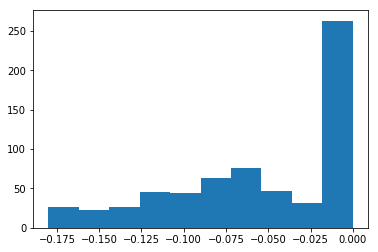

In [26]:
plt.hist([inp_dict['acceptor_magnitude'] for inp_dict in calc_feat_Co23Fe34.values()])

In [110]:
fit_agg.sort_values(by='Point')

,,R2,atm,b,m,bad_flag,E_a
Point,formula,,,,,,
1.0,Ba0.76069Co0.58822Fe0.21878Y0.03526Zr0.15775O3,"[0.9887472662829075, 0.9419066529075528]","[dry, wet]","[-15.230830416928711, 3.19116955354645]","[2477.082286514097, -9558.664361974164]","[1, 0]","[-0.21345835500046526, 0.8237016516637082]"
2.0,Ba0.73592Co0.5649Fe0.23298Y0.02772Zr0.1744O3,"[0.36726793325447515, 0.21272455732733153]","[dry, wet]","[-9.7287483388588, -13.43794273774914]","[-1664.8547151392286, -650.6223301630429]","[1, 1]","[0.14346602482410728, 0.05606627324383894]"
3.0,Ba0.76406Co0.54106Fe0.26413Y0.02626Zr0.16855O3,"[0.2886516756295382, 0.07420242935773669]","[dry, wet]","[-10.894701429834017, -16.036425394313653]","[-1416.4570174625576, 756.9797729606091]","[1, 1]","[0.12206077550290621, -0.06523144506926645]"
4.0,Ba0.74896Co0.49822Fe0.29405Y0.0341Zr0.17363O3,"[0.943606381174278, 0.9982222758811028]","[dry, wet]","[-6.4437191423888915, -8.620634525816428]","[-3971.8981130372713, -3370.101586192099]","[0, 0]","[0.3422715676641947, 0.2904127750174076]"
5.0,Ba0.76672Co0.47062Fe0.33276Y0.04311Zr0.1535O3,"[0.9880385371645973, 0.9942103519307639]","[dry, wet]","[-6.924856201861007, -7.416587501480644]","[-3842.985354856363, -4126.8542848094785]","[0, 0]","[0.3311627298796438, 0.35562465234117263]"
6.0,Ba0.76662Co0.42018Fe0.35835Y0.0362Zr0.18528O3,"[0.9392472947168421, 0.9808242790718684]","[dry, wet]","[-8.171448363800474, -8.976109178265371]","[-3467.7923665571034, -3512.965407917376]","[0, 0]","[0.29883111194103523, 0.30272382198608644]"
7.0,Ba0.76419Co0.37123Fe0.38224Y0.04981Zr0.19673O3,"[0.011127257416433056, 0.8667014033229796]","[dry, wet]","[-15.454546831355044, -12.0535916532392]","[412.49006702062184, -2070.255943513956]","[1, 0]","[-0.03554563029238815, 0.1784007864972112]"
8.0,Ba0.80221Co0.3391Fe0.44135Y0.02912Zr0.19043O3,"[0.028661504844950114, 0.7874554787322654]","[dry, wet]","[-14.052986165825594, 5.6685865079527975]","[-456.6900002435087, -12146.938978700058]","[1, 1]","[0.039354484397983946, 1.0467418166932136]"
9.0,Ba0.8117Co0.28602Fe0.47365Y0.03216Zr0.20817O3,"[0.16551924350969738, 0.9155385358887115]","[dry, wet]","[-19.15771852956497, -9.849069633624879]","[2241.823069245669, -3555.7524835623135]","[1, 0]","[-0.1931852918930278, 0.3064109254917603]"


In [98]:
filename = 'PDAC_COM3_01488_x_mm;y_mm;Ba_at;Zr_at;Y_at;Co_at;Fe_at;ASR;Temp_C;_300C_wet.txt'
file = os.path.join('C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\data\\eis\\in\\PDAC_COM3_01488',
                   filename)
df = fl.read_datafile(file)
df['ASR'].replace(0,np.nan,inplace=True)
df

,x_mm,y_mm,Ba_at,Zr_at,Y_at,Co_at,Fe_at,ASR,Temp_C,Point,T_set,atm
Point_info,,,,,,,,,,,,
1_300C_wet,0,0.00,0.476882,0.121656,0.028611,0.213371,0.159480,NaN,265,1,300C,wet
2_300C_wet,-4,0.00,0.476321,0.128210,0.029056,0.198322,0.168090,NaN,265,2,300C,wet
3_300C_wet,-8,0.00,0.479090,0.130038,0.029220,0.185514,0.176138,NaN,265,3,300C,wet
4_300C_wet,-12,0.00,0.477090,0.133317,0.031946,0.173065,0.184582,NaN,265,4,300C,wet
5_300C_wet,-16,0.00,0.478171,0.134276,0.033580,0.160420,0.193553,NaN,265,5,300C,wet
6_300C_wet,-20,0.00,0.477311,0.137483,0.035738,0.148771,0.200697,NaN,265,6,300C,wet
7_300C_wet,-24,0.00,0.477260,0.142120,0.034906,0.138017,0.207698,NaN,265,7,300C,wet
8_300C_wet,-28,0.00,0.476800,0.140269,0.035279,0.130273,0.217380,NaN,265,8,300C,wet
9_300C_wet,-32,0.00,0.477036,0.142283,0.035225,0.122659,0.222797,NaN,265,9,300C,wet


In [22]:
"create dataset if not existing"
# client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')
# dataset = client.create_dataset(name='TCO EIS data',
#                                 description='Activation energies derived from EIS data for TCO thin films',
#                                 public=0)

# dataset.id

162329

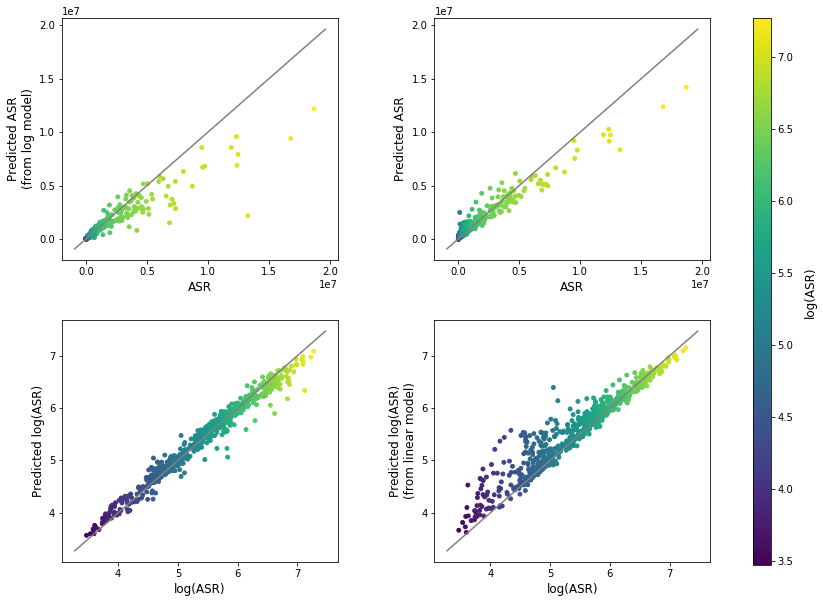

In [291]:

srcdir = os.path.join(pifdir,'dryASR_Co(2,3)Fe(3,4)')
pifs = []
for file in glob.glob(os.path.join(srcdir,'*.json')):
    with open(file,'r') as f:
        fp = pypif.pif.load(f)
        pifs += fp

view_id = 5046
predict = ['ASR','logASR']
exclude = ['formula']
condition = {'Atmosphere':'dry','Temperature ($^\\circ$C)':437}
result = predict_from_pifs(view_id,pifs,predict,exclude=exclude,condition=condition)


result['pred_ASR_fromlog'] = 10**result['pred_logASR']
result['pred_logASR_fromASR'] = np.log10(result['pred_ASR'])

fig, axes = plt.subplots(2,2,figsize=(12,10))
fs = 12
xaxes = np.array([['ASR','ASR'],['logASR','logASR']])
xlabels = np.array([['ASR','ASR'],['log(ASR)','log(ASR)']])
yaxes = np.array([['pred_ASR_fromlog','pred_ASR'],['pred_logASR','pred_logASR_fromASR']])
ylabels = np.array([['Predicted ASR\n(from log model)','Predicted ASR'],
                    ['Predicted log(ASR)','Predicted log(ASR)\n(from linear model)']])

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i,j]
        xax = xaxes[i,j]
        yax = yaxes[i,j]
        xlab = xlabels[i,j]
        ylab = ylabels[i,j]
        ax.scatter(result[xax],result[yax],s=15,c=result['logASR'])
        
        ax.plot(ax.get_xlim(),ax.get_xlim(),c='gray')
        ax.set_xlabel(xlab,size=fs)
        ax.set_ylabel(ylab,size=fs)

add_colorbar(fig=fig,ax=axes,subplots_adjust={},vmin=result['logASR'].min(),vmax=result['logASR'].max(),
            label='log(ASR)',cbrect=[0.85,0.12,0.02,0.76],labelkwargs={'size':fs,'labelpad':10},
            tickparams={'labelsize':fs-2})

In [275]:
help(add_colorbar)

Help on function add_colorbar in module helpers.plotting:

add_colorbar(fig=None, ax=None, cbrect=[0.9, 0.15, 0.02, 0.75], label=None, tickformat=None, cmap=<matplotlib.colors.ListedColormap object at 0x000001AF56808A20>, vmin=None, vmax=None, tickparams={}, labelkwargs={}, subplots_adjust={'left': 0.05, 'wspace': 0.35, 'hspace': 0.25, 'right': 0.8})



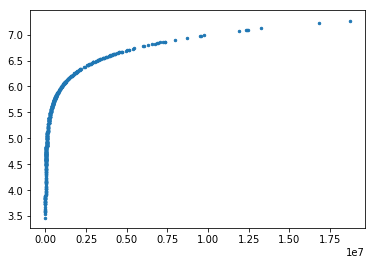

In [229]:
fig, ax = plt.subplots()
ax.scatter(result['ASR'],result['logASR'],s=6)

In [252]:
import itertools
itertools.product([0,1],[0,1])

## Examples of hysteresis and good/bad Arrhenius fits

Text(0.5,1,'Good fits: 01488')

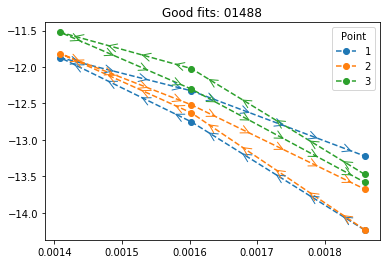

In [28]:
"Arrhenius plots of a few points in a well-behaved library"
df = load_sample('PDAC_COM3_01488',src='Samples')
df['x'] = 1/df['T(K)']
df['y'] = np.log(1/df['ASR'])
df.sort_values(by=['Point','Atmosphere','T_order'],inplace=True)
dry = df[df['Atmosphere']=='dry']
for i in range(1,4):
    ptdf = dry[dry['Point']==i]
    p = plt.plot(ptdf.x,ptdf.y,ls='--',marker='o',label=i)
    plot_misc2.add_arrows(p,xint=0.00005,size=20)
plt.legend(title='Point')
plt.title('Good fits: 01488')


Text(0.5,1,'Bad fits: 01542')

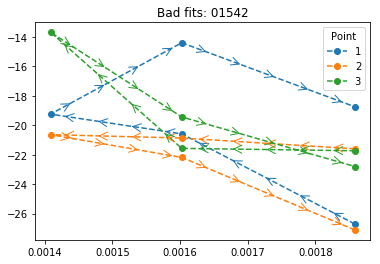

In [29]:
"Arrhenius plots of a few points in a poorly-behaved library"
df = load_sample('PDAC_COM3_01542',src='Samples')
df['x'] = 1/df['T(K)']
df['y'] = np.log(1/df['ASR'])
df.sort_values(by=['Point','Atmosphere','T_order'],inplace=True)
dry = df[df['Atmosphere']=='dry']
for i in range(1,4):
    ptdf = dry[dry['Point']==i]
    p = plt.plot(ptdf.x,ptdf.y,ls='--',marker='o',label=i)
    plot_misc2.add_arrows(p,xint=0.00005,size=20)
plt.legend(title='Point')
plt.title('Bad fits: 01542')